In [38]:
import lzma
import dill as pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import threading
import matplotlib.pyplot as plt
import yfinance as yf
from bs4 import BeautifulSoup
from datetime import datetime
import requests
from bs4 import BeautifulSoup
import pytz
from scipy.optimize import minimize


def get_sp500_tickers():
    # Wikipedia URL for the S&P 500 companies
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

    res = requests.get(url)
    soup = BeautifulSoup(res.content, "html.parser")

    # Find the table containing the S&P 500 tickers
    table = soup.find_all("table")[0]
    df = pd.read_html(str(table))
    return list(df[0].Symbol)

def load_pickle(path):
    with lzma.open(path, "rb") as fp:
        file = pickle.load(fp)
    return file


def save_pickle(path, obj):
    with lzma.open(path, "wb") as fp:
        file = pickle.dump(obj, fp)
    return file

def vwap(prices, volumes, window):
    """
    prices: A pandas Series of prices.
    volumes: A pandas Series of volumes corresponding to the prices.
    window: The time window for which to calculate the VWAP values.
    Returns a pandas Series of VWAP values for the given time window.
    """
    df = pd.DataFrame({'prices': prices, 'volumes': volumes})
    total_value = df['prices'] * df['volumes']
    total_volume = df['volumes']
    vwap_values = (total_value.rolling(window=window).sum() /
                   total_volume.rolling(window=window).sum()).fillna(0)
    return vwap_values


def get_history(ticker, start, end, interval="1d", tries=0):
    try:
        df = yf.Ticker(ticker).history(start=start,
                                       end=end,
                                       interval=interval,
                                       auto_adjust=True
                                       ).reset_index()
    except Exception as err:

        if tries < 5:
            return get_history(ticker, start, end, interval, tries+1)
        return pd.DataFrame()
    try:
        df = df.rename(columns={
            "Date": "datetime",
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Volume": "volume"
        })
        df = df.drop(columns=["Dividends", "Stock Splits"])
    except:
        pass

    if df.empty:
        return pd.DataFrame()
    df["datetime"] = df["datetime"].dt.tz_localize(
        None).dt.tz_localize(pytz.utc)
    df = df.set_index("datetime", drop=True)
    print(ticker)
    return pd.DataFrame(df)


def get_histories(tickers, period_start, period_end):
    dfs = [None] * len(tickers)
    filterd_tickers = []  # gets correct ticker list incl in dfs

    def _helper(i):
        df = get_history(tickers[i],
                         period_start[i],
                         period_end[i])
        dfs[i] = df
        if not df.empty:
            filterd_tickers.append(tickers[i])

    threads = [threading.Thread(target=_helper, args=(i,))
               for i in range(len(tickers))]
    [thread.start() for thread in threads]
    [thread.join()for thread in threads]
    return dfs, filterd_tickers


def get_ticker_df(start, end):
    from utils import load_pickle, save_pickle
    try:
        tickers, tickers_dfs = load_pickle("dataset.obj")
    except Exception as err:
        # Gets a dictionary that maps ticker to df
        tickers = get_sp500_tickers()
        starts, ends = [start]*len(tickers), [end]*len(tickers)
        dfs, tickers = get_histories(
            tickers=tickers,
            period_start=starts,
            period_end=ends
        )
        tickers_dfs = {ticker: df for ticker, df in zip(tickers, dfs)}
        save_pickle("dataset.obj", obj=(tickers, tickers_dfs))
    return tickers, tickers_dfs



tickers=get_sp500_tickers()

tz_utc = pytz.utc
per_start = datetime(2016, 1, 1, tzinfo=tz_utc)
per_stop = datetime.now(tz_utc)
tickers, dict_tickers = get_ticker_df(start=per_start, end=per_stop)

test_no = 50
tickers = tickers[:test_no]

In [39]:
for ticker in tickers:
    dict_tickers[ticker]["vwap_200"] = dict_tickers[ticker]['vwap_200'] = vwap(
                prices=dict_tickers[ticker]['close'], volumes=dict_tickers[ticker]['volume'], window=200)

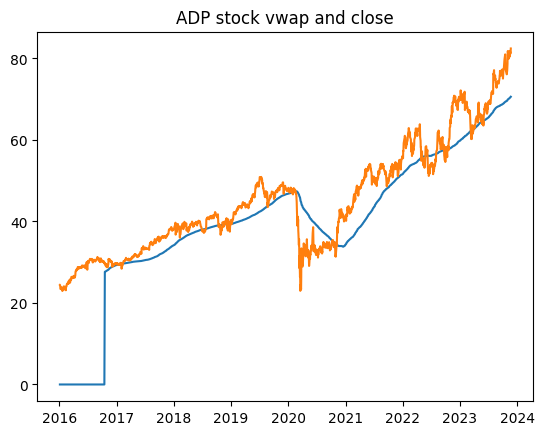

In [42]:
i=9

plt.plot(dict_tickers[tickers[i]]["vwap_200"])
plt.plot(dict_tickers[tickers[i]]["close"])
plt.title(tickers[i] + " stock vwap and close")
plt.show()

Goal is to create an optimized buy and sell signal without manual adj

ETR


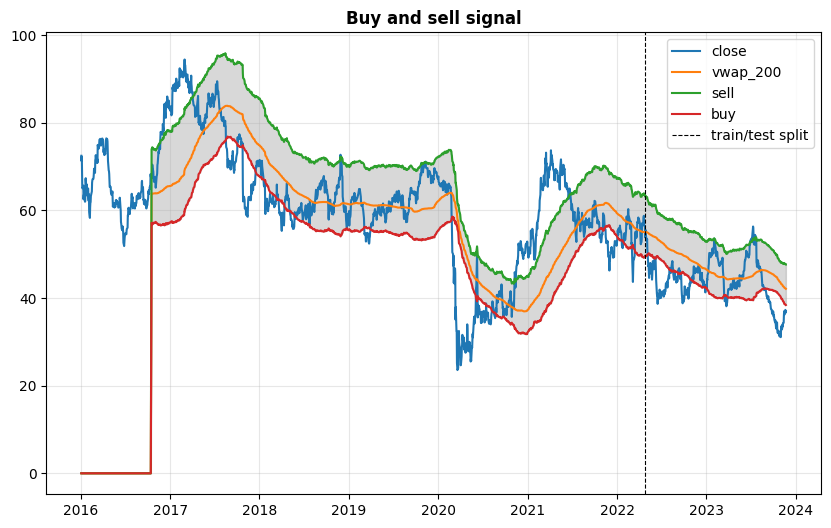

In [131]:
def illustration_optimize_buy_sell_signal(df, b_0, s_0, train_end="none"):
    # test end splits train and test set
    if train_end == "none":
        train_end = int(len(df)*0.8)

    # set division    
    df_train = df[:train_end]
    df_test = df[train_end:]

    buy = pd.Series(
        np.where(df["vwap_200"] != 0,
                 df["vwap_200"] - b_0 * df["close"], 0),
                 index=df.index,
                 name="buy")
    sell = pd.Series(
        np.where(df["vwap_200"] != 0,
                 df["vwap_200"] + s_0 * df["close"], 0),
                 index=df.index,
                 name="sell")

    plt.figure(figsize=(10, 6))  # Adjust the width and height as needed
    plt.plot(df["close"], label="close")
    plt.plot(df["vwap_200"], label="vwap_200") 
    plt.plot(sell, label="sell")
    plt.plot(buy, label="buy")
    plt.fill_between(df.index, buy, sell, color="grey", alpha=0.3)
    plt.axvline(x=df_train.index[-1], color="black", linestyle="--", label="train/test split", linewidth=0.8)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.title("Buy and sell signal", fontweight="bold")
    plt.show()

    # return optimal_buy, optimal_sell


i = 14

print(tickers[i])
illustration_optimize_buy_sell_signal(df=dict_tickers[tickers[i]], b_0=0.1, s_0=0.15, train_end="none")

In [76]:
from scipy.optimize import minimize


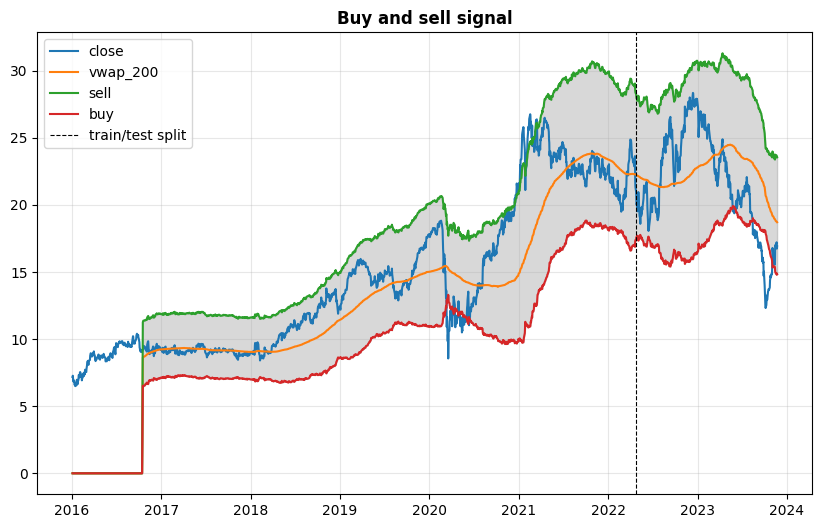

In [132]:
def trading_strategy(df, b, s):
    buy = pd.Series(
        np.where(df["vwap_200"] != 0,
                 df["vwap_200"] - b * df["close"], 0),
                 index=df.index,
                 name="buy")
    sell = pd.Series(
        np.where(df["vwap_200"] != 0,
                 df["vwap_200"] + s * df["close"], 0),
                 index=df.index,
                 name="sell")

    portfolio = pd.DataFrame(index=df.index, columns=["shares", "cash", "total"]).fillna(0)
    portfolio["cash"] = 100
    portfolio["shares"] = 0

    for i in range(len(portfolio)):
        if df["vwap_200"][i] == 0:
            pass
        else:
            if df["close"][i] < buy[i] and portfolio["shares"][i] == 0:
                try:
                    portfolio["shares"][i+1:] += portfolio["cash"][i] / df["open"][i+1]
                    portfolio["cash"][i+1:] = 0
                except IndexError:
                    pass
            elif df["close"][i] > sell[i] and portfolio["shares"][i] != 0:
                try:
                    portfolio["cash"][i+1:] += portfolio["shares"][i] * df["open"][i+1]
                    portfolio["shares"][i+1:] = 0
                except IndexError:
                    pass
            else:
                pass

    portfolio["total"] = portfolio["cash"] + portfolio["shares"] * df["close"]

    portfolio_value = portfolio["cash"][-1] + portfolio["shares"][-1] * df["close"][-1]
    total_returns = portfolio_value / portfolio["cash"][0] - 1
    return total_returns


def utility_function(params, df):
    b,s = params
    return -trading_strategy(df=df, b=b, s=s)


def optimize_buy_sell_signal(df, b_0, s_0, train_end="none", method="Powell", maxiter=500):
    # test end splits train and test set
    if train_end == "none":
        train_end = int(len(df)*0.8)
    # else, train_end needs to be int

    # set division    
    df_train = df[:train_end]
    df_test = df[train_end:]

    initial_guess = [b_0, s_0]
    
    # Optimize buy and sell signal with bounds
    bounds = [(0, 0.3), (0, 0.3)]
    result = minimize(utility_function, initial_guess, args=df_train, method=method, bounds=bounds, options={'maxiter': maxiter})
    optimal_buy, optimal_sell = result.x
    return optimal_buy, optimal_sell


def test_strat(df, b, s):
    
    # dif with trading_strategy is that this one returns the portfolio

    buy = pd.Series(
        np.where(df["vwap_200"] != 0,
                 df["vwap_200"] - b * df["close"], 0),
                 index=df.index,
                 name="buy")
    sell = pd.Series(
        np.where(df["vwap_200"] != 0,
                 df["vwap_200"] + s * df["close"], 0),
                 index=df.index,
                 name="sell")
    portfolio = pd.DataFrame(index=df.index,
                            columns=["shares", "cash", "total"]).fillna(0)
    portfolio["cash"] = 100
    portfolio["shares"] = 0

    for i in range(len(portfolio)):
        if df["vwap_200"][i] == 0:
            pass
        else:
            if df["close"][i] < buy[i] and portfolio["shares"][i] == 0:
                try:
                    portfolio["shares"][i+1:] += portfolio["cash"][i] / df["open"][i+1]
                    portfolio["cash"][i+1:] = 0
                except IndexError:
                    pass
            elif df["close"][i] > sell[i] and portfolio["shares"][i] != 0:
                try:
                    portfolio["cash"][i+1:] += portfolio["shares"][i] * df["open"][i+1]
                    portfolio["shares"][i+1:] = 0
                except IndexError:
                    pass
            else:
                pass
    portfolio["total"] = portfolio["cash"] + portfolio["shares"] * df["close"]
    return portfolio




i=8
b, s = optimize_buy_sell_signal(df=dict_tickers[tickers[i]], b_0=0.1, s_0=0.15, train_end="none")
illustration_optimize_buy_sell_signal(df=dict_tickers[tickers[i]], b_0=b, s_0=s, train_end="none")



In [116]:
# set division    
from scipy.optimize import differential_evolution
import warnings
warnings.filterwarnings("ignore")




i=14
df = dict_tickers[tickers[i]]

method = "SLSQP"
maxiter = 10000

train_end = int(len(df)*0.8)
df_train = df[:train_end]

initial_guess = [0.1, 0.15] # b_0, s_0

# optimize buy and sell signal
# r = minimize(utility_function, initial_guess, args=df_train, method=method, options={'maxiter': maxiter})

r = differential_evolution(utility_function, bounds=[(0, 1), (0, 1)], args=df_train)

print(r)



RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'